# Covariance matrix for X

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
import numpy.random
import scipy
from scipy import integrate
from numpy import sin, cos, pi
#import pycbc.psd

In [3]:
def covX(dur, tau2, tau3, dt, fs, fmin, fmax, tag1, tag2):

    
    freq = np.logspace(-5, 0, 5000)
    w    = 2*np.pi*freq
    
    ### Getting total noise PSD S_N
    ## Shot noise PSD
    n1_psd = n1p_psd = n2p_psd = n3_psd = (6e-12)**2
    S_n_shot_x = 2.*(n1_psd*(1-cos(2*w*tau2)) + n1p_psd*(1-cos(2*w*tau3)) + n2p_psd*(1-cos(w*(tau3+2*tau2))) + n3_psd*(1-cos(w*(tau2+2*tau3))))

    # TM-motion PSD
    delta1_psd = delta1p_psd = delta2p_psd = delta3_psd = (2.4e-15)**2
    S_n_delta_x  = 8*delta1_psd*(1 + cos(w*2*tau2) - cos(w*2*tau3) - cos(2*w*(tau2+tau3))) + 8*delta2p_psd*(1-cos(2*w*tau2)) + 8*delta3_psd*(1-cos(2*w*tau3))
    S_n_delta_x *= (1 + ((0.4e-3)/freq)**2)*(1 + (freq/(8e-3))**4)/(w**4) # Shaping the noise

    ## DWS noise PSD
    # Yaw
    c1 = c1p = c1_FS = c1p_FS = c2 = c2p = c2_FS = c2p_FS = c3 = c3p = c3_FS = c3p_FS = 5e-3 # Upper bound on coeffs
    n_phi1_psd = n_phi1p_psd = n_phi2p_psd = n_phi3_psd = ((35e-9)/300.)**2
    
    S_n_phi_x  = n_phi1_psd*(c1**2 + c2p_FS**2 + 2*c1*c2p_FS*cos(2*w*tau3))*(2-2*cos(2*w*tau2))
    S_n_phi_x += n_phi1p_psd*(c1p**2 + c3_FS**2 + 2*c1p*c3_FS*cos(2*w*tau2))*(2-2*cos(2*w*tau3))
    S_n_phi_x += n_phi2p_psd*(c2p**2 + c1_FS**2 + 2*c2p*c1_FS)*(2-2*cos(2*w*tau2))
    S_n_phi_x += n_phi3_psd*(c3**2 + c1p_FS**2 + 2*c3*c1p_FS)*(2-2*cos(2*w*tau3))
    #S_n_phi_x *= 0
    
    # Pitch signal as noise
    if tag2=='LPF':
        w0 = 2*np.pi*(3e-3)
        w1 = 2*np.pi*(4e-3)
        w2 = 2*np.pi*(1e-1) 
        eta1_psd = eta1p_psd = eta2p_psd = eta3_psd = ((6e-9)*(w**2 + w0**2)/((w**2 + w1**2)*(w**2 + w2**2)))**2
        theta1_psd = theta1p_psd = theta2p_psd = theta3_psd = ((4e-8)*(w**2 + w0**2)/((w**2 + w1**2)*(w**2 + w2**2)))**2
    else:
        eta1_psd = eta1p_psd = eta2p_psd = eta3_psd = ((10.0e-9)**2)*(1 + ((0.8e-3)/freq)**4)
        theta1_psd = theta1p_psd = theta2p_psd = theta3_psd = ((10.0e-9)**2)*(1 + ((0.8e-3)/freq)**4)
    
    # Upper bound on coeffs
    c1_eta = c1p_eta = c1_FS_eta = c1p_FS_eta = c2_eta = c2p_eta = c2_FS_eta = c2p_FS_eta = c3_eta = c3p_eta = c3_FS_eta = c3p_FS_eta = 5e-3 
    
    theta_o    = 30.*pi/180 # Half of opening angle b/w MOSAs
    S_n_eta_x  = (eta1_psd*cos(theta_o)**2 + theta1_psd*sin(theta_o)**2)*(c1_eta**2 + c2p_FS_eta**2 + 2*c1_eta*c2p_FS_eta*cos(2*w*tau3))*(2-2*cos(2*w*tau2))
    S_n_eta_x += (eta1p_psd*cos(theta_o)**2 + theta1p_psd*sin(theta_o)**2)*(c1p_eta**2 + c3_FS_eta**2 + 2*c1p_eta*c3_FS_eta*cos(2*w*tau2))*(2-2*cos(2*w*tau3))
    S_n_eta_x += (eta2p_psd*cos(theta_o)**2 + theta2p_psd*sin(theta_o)**2)*(c2p_eta**2 + c1_FS_eta**2 + 2*c2p_eta*c1_FS_eta)*(2-2*cos(2*w*tau2))
    S_n_eta_x += (eta3_psd*cos(theta_o)**2 + theta3_psd*sin(theta_o)**2)*(c3_eta**2 + c1p_FS_eta**2 + 2*c3_eta*c1p_FS_eta)*(2-2*cos(2*w*tau3))
    #S_n_eta_x *= 0
    
    ## GW noise PSD
    m1, m2, f1, f2 = -0.34020763866501563, -7.956580873845239, 2.000050001250031e-05, 0.019400485012125303
    ampsq = (0.3e-23)**2

    S_gw_estimate  = ampsq
    S_gw_estimate *= (freq**2 + f1**2)**(m1)
    S_gw_estimate *= (freq**2 + f2**2)**(m2-m1)

    # Total noise S_N = shot noise + TM-motion noise + GW noise + DWS noise
    S_N = S_n_shot_x + S_n_delta_x + S_gw_estimate + S_n_phi_x + S_n_eta_x
    S_N_vec = [S_n_shot_x, S_n_delta_x, S_gw_estimate, S_n_phi_x, S_n_eta_x]
    
    
    ## Integrands    
    ## DWS signals
    if tag2 == 'LPF':
        w0_y = 2*np.pi*(3.75e-3)
        w1_y = 2*np.pi*(4.5e-3)
        w2_y = 2*np.pi*(1e-1)                   
        phi1_psd = phi1p_psd = phi2p_psd = phi3_psd = ((4e-9)*(w**2 + w0_y**2)/((w**2 + w1_y**2)*(w**2 + w2_y**2)))**2
        
    else:
        phi1_psd  = phi1p_psd = phi2p_psd = phi3_psd = ((10.0e-9)**2)*(1 + ((0.8e-3)/freq)**4)
        
    H_modsq1 = 2 - 2*cos(2*w*tau2)
    H_modsq2 = 2 - 2*cos(2*w*tau3)
    
    # |H|^2 |phi|^2 ~ |H|^2 phi_psd*T
    d11 = integrate_fn(H_modsq1*phi1_psd*dur, S_N, w, fmin, fmax)
    d12 = integrate_fn(H_modsq1*phi1_psd*dur*cos(2*w*tau3), S_N, w, fmin, fmax)
    d33 = integrate_fn(H_modsq2*phi1p_psd*dur, S_N, w, fmin, fmax)
    d34 = integrate_fn(H_modsq2*phi1p_psd*dur*cos(2*w*tau2), S_N, w, fmin, fmax)
    d55 = integrate_fn(H_modsq1*phi2p_psd*dur, S_N, w, fmin, fmax)
    d66 = integrate_fn(H_modsq2*phi3_psd*dur, S_N, w, fmin, fmax)

    d_vec = d11, d12, d33, d34, d55, d66

    cov_x = np.asarray(make_covX_matrix(d_vec, dur))

    if tag1 == 'plot':  
        return cov_x, H_modsq1, phi1_psd*dur, S_N_vec, freq
    else: 
        return cov_x
    
def make_covX_matrix(d_vec, dur):
    
    d11, d12, d33, d34, d55, d66 = d_vec
    
    matrix = [[d11/(d11**2 - d12**2), d12/(-d11**2 + d12**2), 0, 0, 0, 0], [d12/(-d11**2 + d12**2), d11/(d11**2 - d12**2), 0, 0, 0, 0],[0, 0, d33/(d33**2 - d34**2), d34/(-d33**2 + d34**2), 0, 0], [0, 0, d34/(-d33**2 + d34*2), d33/(d33**2 - d34**2), 0, 0], [0, 0, 0, 0, 1./d55, 0], [0, 0, 0, 0, 0, 1./d66]]
    return matrix


def integrate_fn(numerator, S_N, w, wmin, wmax):

    integrand = numerator/S_N
    
    # Set limits and resize arrays before integral
    w_max_idx = find_nearest(w, wmax)
    w = w[:w_max_idx+1] # +1 to include the index with value closest to wmax
    
    w_min_idx = find_nearest(w, wmin)
    w = w[w_min_idx:]
    
    integrand = integrand[w_min_idx:w_max_idx+1]
    result    = integrate.simps(integrand, x=w, axis=-1, even='avg')

    return result

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def return_diag_covx(covx):
    
    return covx[0][0]**0.5, covx[1][1]**0.5, covx[2][2]**0.5, covx[3][3]**0.5, covx[4][4]**0.5, covx[5][5]**0.5
    
    
    

In [4]:
fs  = 8.
dt  = 1./fs
c   = 299792458
dur = 1*24*3600 # 1 day
#dur = 10*60 # 10 mins
wmin = 2*np.pi*1./dur
#wmax = 2*np.pi*4e-2
wmax = 2*np.pi

DWS  = 'LPF'
tau2 = 2.5e9/3e8
tau3 = 2.5e9/3e8

print('T = ', dur)
print('Integration limits: ', wmin, wmax)

T =  86400
Integration limits:  7.27220521664304e-05 6.283185307179586


In [5]:
covX_matrix, H_modsq, phi1_modsq, S_N_vec, freq =  covX(dur, tau2, tau3, dt, fs, wmin, wmax, 'plot', DWS)

print('\n')
print('\n'.join([' '.join(['{:4}'.format(item) for item in row]) 
      for row in covX_matrix]))



1.9370216643537143e-08 4.334668684908103e-09  0.0  0.0  0.0  0.0
4.334668684908103e-09 1.9370216643537143e-08  0.0  0.0  0.0  0.0
 0.0  0.0 1.9370216643537143e-08 4.334668684908103e-09  0.0  0.0
 0.0  0.0 4.117599169522056e-09 1.9370216643537143e-08  0.0  0.0
 0.0  0.0  0.0  0.0 1.8400204126191757e-08  0.0
 0.0  0.0  0.0  0.0  0.0 1.8400204126191757e-08


In [6]:
# Trace of CovX for current integration bounds seen above

for i in range(6):
    print(0.25*covX_matrix[i][i]**0.5)
    
#print(covX_matrix[0][0]/covX_matrix[5][5])

3.479423142161746e-05
3.479423142161746e-05
3.479423142161746e-05
3.479423142161746e-05
3.391183801988599e-05
3.391183801988599e-05


In [7]:
# Getting arm lengths data from LISA orbit simulator

orbit_time, L12, L13, L23 = np.loadtxt("/Users/danielgeorge/Desktop/Workspace/UF/Research/LISA/Simulations/TTL_TDI/spring_2021/Data/Distances.txt", delimiter=',', unpack=True)

N_samples = 1000#len(L12)

orbit_time = orbit_time[:N_samples]
L12 = L12[:N_samples]
L13 = L13[:N_samples]
L23 = L23[:N_samples]

tau2_vec = L12/c
tau3_vec = L13/c

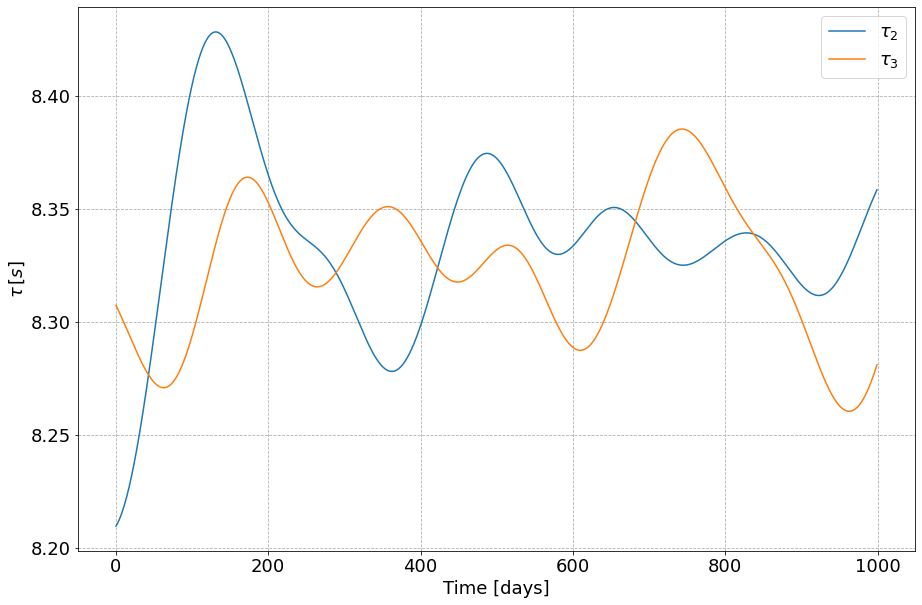

In [8]:
fig = plt.figure(figsize=(15, 10))
plt.plot(orbit_time, tau2_vec, label='$\\tau_2$')
plt.plot(orbit_time, tau3_vec, label='$\\tau_3$')
plt.ylabel('$\\tau \,[s]$')
plt.xlabel('Time [days]')
plt.legend()
plt.grid(True, which="both", ls="--")

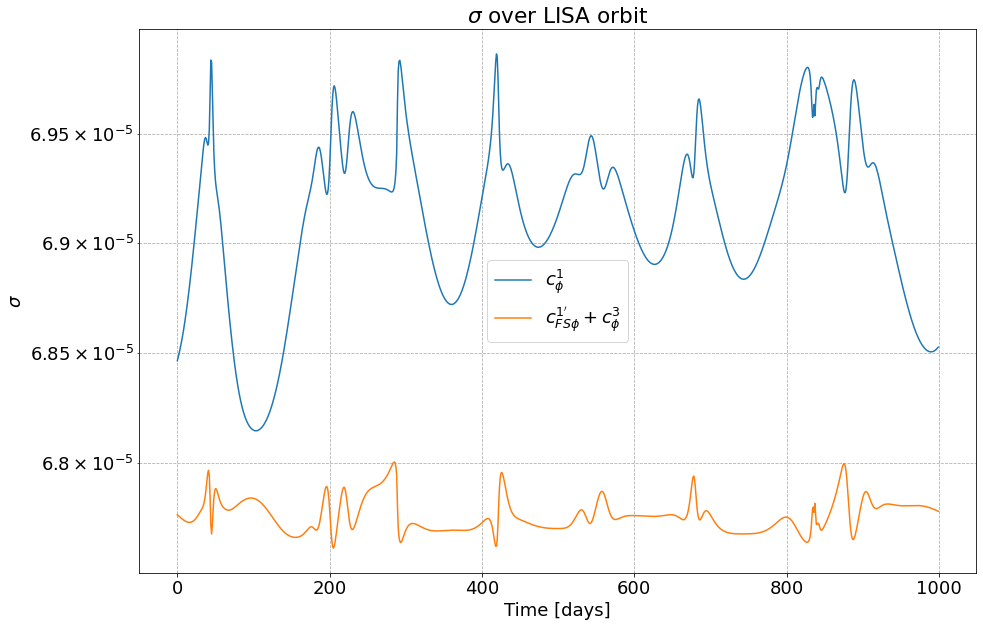

In [9]:
s11_vec = []
s12_vec = []
s66_vec = []

for i in range(len(orbit_time)):
    
    tau2 = tau2_vec[i]
    tau3 = tau3_vec[i]
    
    covX_matrix =  covX(dur, tau2, tau3, dt, fs, wmin, wmax, 'no-plot', DWS)
    s11 = 0.5*covX_matrix[0][0]**0.5
    s12 = 0.5*covX_matrix[0][1]**0.5
    s22 = 0.5*covX_matrix[1][1]**0.5
    s33 = 0.5*covX_matrix[2][2]**0.5
    s44 = 0.5*covX_matrix[3][3]**0.5
    s55 = 0.5*covX_matrix[4][4]**0.5
    s66 = 0.5*covX_matrix[5][5]**0.5
    
    s11_vec.append(s11)
    s12_vec.append(s12)
    s66_vec.append(s66)


fig = plt.figure(figsize=(15, 10))
plt.title('$\sigma$ over LISA orbit')
plt.semilogy(orbit_time, s11_vec, label='$c_{\\phi}^1$')
plt.semilogy(orbit_time, s66_vec, label='$c_{FS\\phi}^{1^{\prime}} + c_{\\phi}^{3}$')
#plt.semilogy(orbit_time, tau2_vec, label='$\\tau_2$')
#plt.loglog(orbit_time, s11_vec, label='$c_{\\phi}^1$')
#plt.loglog(orbit_time, s66_vec, label='$c_{FS\\phi}^{1^{\prime}} + c_{\\phi}^{3}$')
plt.ylabel('$\sigma$')
plt.xlabel('Time [days]')
plt.legend()
plt.grid(True, which="both", ls="--")

Text(0, 0.5, '$\\Delta \\tau [s]$')

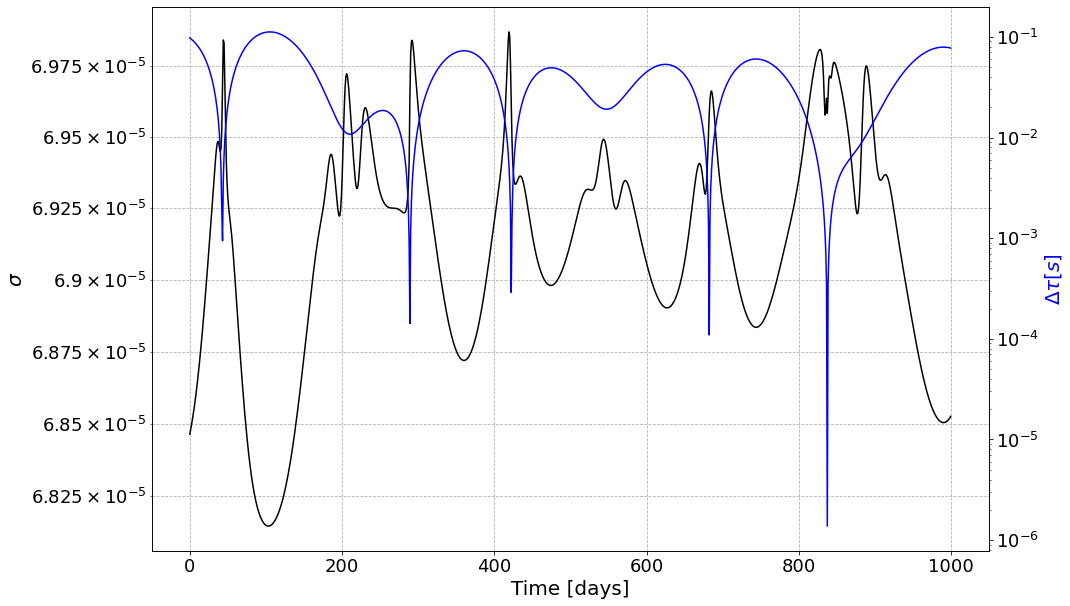

In [10]:
# create figure and axis objects with subplots()

fig,ax = plt.subplots(figsize=(15, 10))
# make a plot
ax.semilogy(orbit_time, s11_vec, c="k", label='$c_{\\phi}^1$')
plt.grid(True, which="both", ls="--")
#ax.semilogy(orbit_time, s66_vec, label='$c_{FS\\phi}^{1^{\prime}} + c_{\\phi}^{3}$')
ax.set_xlabel("Time [days]",fontsize=20)
ax.set_ylabel("$\sigma$",c="k",fontsize=20)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.semilogy(orbit_time, abs(tau2_vec-tau3_vec), c="blue")
ax2.set_ylabel("$\\Delta \\tau [s]$",c="blue",fontsize=20)

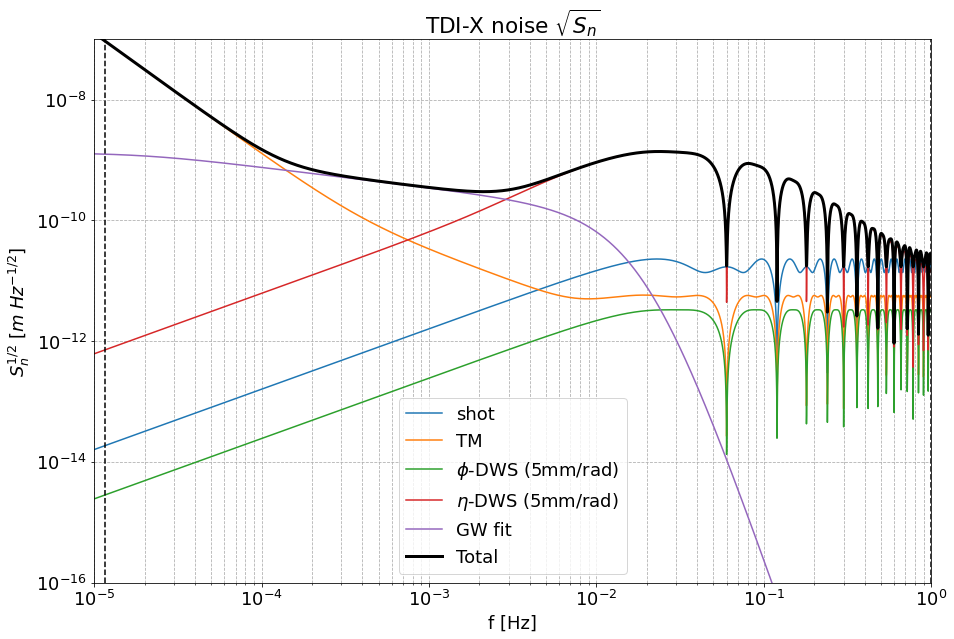

In [11]:
# Plotting various noise curves


S_n_shot_x, S_n_delta_x, S_gw_estimate, S_n_phi_x, S_n_eta_x = S_N_vec 
S_n = S_n_shot_x + S_n_delta_x + S_gw_estimate + S_n_phi_x + S_n_eta_x

fig = plt.figure(figsize=(15, 10))
plt.title('TDI-X noise $\\sqrt{S_n}$')
plt.loglog(freq, S_n_shot_x**0.5, label='shot')
plt.loglog(freq, S_n_delta_x**0.5, label='TM')
plt.loglog(freq, S_n_phi_x**0.5, label='$\phi$-DWS (5mm/rad)')
plt.loglog(freq, S_n_eta_x**0.5, label='$\eta$-DWS (5mm/rad)')
plt.loglog(freq, S_gw_estimate**0.5, label='GW fit')
plt.loglog(freq, S_n**0.5, label='Total', c='k', linewidth=3.0)
plt.ylabel('$S_n^{1/2}$ $[m \; Hz^{-1/2}]$')
plt.xlabel('f [Hz]')
plt.xlim([1e-5, 1])
plt.ylim([1e-16, 1e-7])
#plt.axvline(x=3e-3, ls='--', c='k')
plt.axvline(x=wmin/(2*np.pi), ls='--', c='k')
plt.axvline(x=wmax/(2*np.pi), ls='--', c='k')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.savefig('Figures/FIM_noise_%s-DWS.png'%DWS, bbox_inches = 'tight', pad_inches = 0)

In [12]:
# Checking noise, signal at three difference cases of delta_tau: highes, med, lowes

delta_tau = abs(tau2_vec-tau3_vec)

d_tau_low_idx  = find_nearest(delta_tau, 0)
d_tau_high_idx = find_nearest(delta_tau, max(delta_tau))
d_tau_med_idx  = find_nearest(delta_tau, max(delta_tau)/2.)

tau2_low  = tau2_vec[d_tau_low_idx]
tau3_low  = tau3_vec[d_tau_low_idx]
tau2_high = tau2_vec[d_tau_high_idx]
tau3_high = tau3_vec[d_tau_high_idx]
tau2_med  = tau2_vec[d_tau_med_idx]
tau3_med  = tau3_vec[d_tau_med_idx]

In [13]:
covX_matrix_low, H_modsq1_low, phi1_modsq_low, S_N_vec_low, freq =  covX(dur, tau2_low, tau3_low, dt, fs, wmin, wmax, 'plot', DWS)
s11_low = 0.5*covX_matrix_low[0][0]**0.5
num_low = H_modsq1_low*phi1_modsq_low


covX_matrix_med, H_modsq1_med, phi1_modsq_med, S_N_vec_med, freq =  covX(dur, tau2_med, tau3_med, dt, fs, wmin, wmax, 'plot', DWS)
s11_med = 0.5*covX_matrix_med[0][0]**0.5
num_med = H_modsq1_med*phi1_modsq_med

covX_matrix_high, H_modsq1_high, phi1_modsq_high, S_N_vec_high, freq =  covX(dur, tau2_high, tau3_high, dt, fs, wmin, wmax, 'plot', DWS)
s11_high = 0.5*covX_matrix_high[0][0]**0.5
num_high = H_modsq1_high*phi1_modsq_high

print(s11_low, s11_med, s11_high)


6.958424052839049e-05 6.884809339139178e-05 6.814612939114546e-05


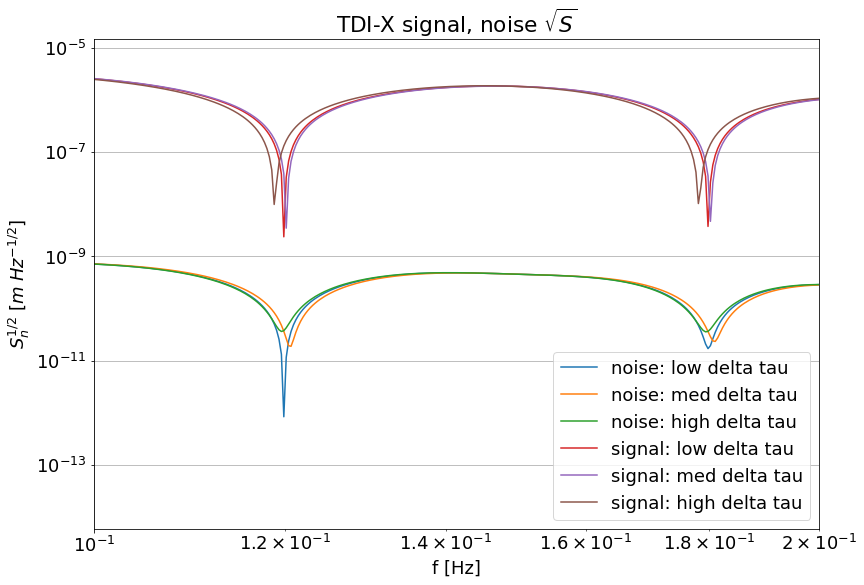

In [21]:
fig = plt.figure(figsize=(13, 9))
plt.title('TDI-X signal, noise $\\sqrt{S}$')
plt.ylabel('$S_n^{1/2}$ $[m \; Hz^{-1/2}]$')
plt.xlabel('f [Hz]')
#plt.loglog(freq, abs(sum(S_N_vec_low)-sum(S_N_vec_med)))
plt.loglog(freq, sum(S_N_vec_low)**0.5,label='noise: low delta tau')
plt.loglog(freq, sum(S_N_vec_med)**0.5, label='noise: med delta tau')
plt.loglog(freq, sum(S_N_vec_high)**0.5, label='noise: high delta tau')
#plt.xlim([4e-2, 7e-2])
plt.xlim([1e-1, 2e-1])
plt.loglog(freq, num_low**0.5, label='signal: low delta tau')
plt.loglog(freq, num_med**0.5, label='signal: med delta tau')
plt.loglog(freq, num_high**0.5, label='signal: high delta tau')
plt.grid()
plt.legend()